In [1]:
from __future__ import annotations
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import math
from typing import List, Tuple, Union, Iterable, Callable, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from itertools import count
import gym
import gym.spaces
import seaborn as sns

In [2]:
%matplotlib ipympl
# %matplotlib inline

In [3]:
# config

NUM_VEHICLES                        = 10     #@param {type:"integer"}
NUM_VULNS                           = 1      #@param {type:"integer"}
NUM_ATTACK                          = 2      #@param {type:"integer"}
NUM_STEPS                           = 100    #@param {type:"integer"}
ATTACK_INTERVAL                     = 2

ACTION_K                            = 5      #@param {type:"integer"}

BATCH_SIZE                          = 100    #@param {type:"integer"}

MEMORY_SIZE                         = 1000000  #@param {type:"integer"}
# MEMORY_WARMUP_STEPS                 = MEMORY_SIZE // BATCH_SIZE     #@param {type:"integer"} # scaled by batch size
MEMORY_WARMUP_STEPS                 = 0

TRAIN_STEPS                         = 500     #@param {type:"integer"}

REWARD_GAMMA                        = 0.99   #@param {type:"number"}

EPSILON_START = 0.9
EPSILON_END = 0.05
EPSILON_DECAY = 200
EPSILON_SCALE = 15

POLICY_TARGET_UPDATE_INTERVAL       = 10 #@param {type:"integer"}
SOFT_UPDATE_TAU                     = 0.005  #@param {type:"number"}

EVAL_STEPS                          = 100    #@param {type:"integer"}

DEVICE = torch.cuda.is_available() and torch.device('cuda') or torch.device('cpu')

In [4]:
class MyBox(gym.spaces.Box):
    def __init__(self, low, high):
        super().__init__(low, high)

    def sample(self):
        x = super().sample()
        x[:,:,0] = x[:,:,0] > 0.5
        x[:,:,3] = x[:,:,3] > 0.5
        x[:,:,2] = x[:,:,2].round()
        return x

In [5]:
class PlatoonEnv(gym.Env):
    metadata = {"render.modes": ["human"]}
    def __init__(
        self,
        num_vehicles: int,
        num_vulns: int,
        num_attack: int,
        num_steps: int,
        attack_interval: int,
        render_mode: str,
    ):
        self.num_vehicles = num_vehicles
        self.num_vulns = num_vulns
        self.num_attack = num_attack
        self.num_steps = num_steps
        self.attack_interval = attack_interval
        self.reward_range = (0, num_vehicles)
        self.render_mode = render_mode
        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.font = None
        self.clock = None
        self.isopen = True
        self.latest_reward = None
        self.episode_reward_total = 0
        self.action_space = gym.spaces.Discrete(num_vehicles + 1) # include no-op
        self.observation_space = MyBox(
            # member, prob, sev, compromised
            low=torch.tensor((0,0.0,1,0)).repeat(3,1).repeat(5,1,1).numpy(),
            high=torch.tensor((1,1.0,5,1)).repeat(3,1).repeat(5,1,1).numpy(),
        )
        self.prob_dist = torch.distributions.Normal(
            # loc=torch.as_tensor(0.5),
            loc=torch.as_tensor(0.1),
            scale=torch.as_tensor(0.25),
        )
        self.sev_dist = torch.distributions.Normal(
            loc=torch.as_tensor(2.0),
            scale=torch.as_tensor(1.0),
        )


        self.reset()

    def step(self, action: int) -> Tuple[Tensor, float, bool, dict]:
        if action != self.num_vehicles: # it not no-op
            # toggle membership for the chosen vehicle
            self.state[action,:,0] = 1-self.state[action,:,0]

        if self.current_step % self.attack_interval == 0:
            # prio calculated as sum of the prio of the vulns within the vehicle
            # prio = prob * severity * not_compromised + 100*is_member
            priority = (self.state[:,:,1] * self.state[:,:,2] * (1-self.state[:,:,3]) + (100*self.state[:,:,0])).sum(dim=-1)
            # identify vehicles to attack
            mask = priority.topk(self.num_attack).indices
            attack = self.state[mask]
            # attack proc
            roll = torch.rand(attack.shape[:-1])
            success_mask = roll > 1-attack[:,:,1]
            # update vulnerabilities successfully attacked
            success = attack[success_mask]
            success[:,3] = 1
            # copy data backwards
            attack[success_mask] = success
            self.state[mask] = attack

        # reward starts as the size of the platoon
        reward = self.state[:,:,0].sum(dim=1).count_nonzero()
        # subtract the severity of any compromised vulns within the platoon
        # is_compromised * severity * is_member
        reward -= (self.state[:,:,3] * self.state[:,:,2] * self.state[:,:,0]).sum().int()
        reward = reward.item()

        self.current_step += 1
        done = self.current_step >= self.num_steps
        self.latest_reward = reward
        self.episode_reward_total += reward

        return self.state, reward, done, {}

    def reset(self):
        self.current_step = 0
        self.state = torch.zeros((self.num_vehicles, self.num_vulns, 4))
        self.state[:,:,1] = self.prob_dist.sample(torch.Size((self.num_vehicles, self.num_vulns))).clamp(0,1)
        self.state[:,:,2] = self.sev_dist.sample(torch.Size((self.num_vehicles, self.num_vulns))).round().clamp(1,5)
        novulns = torch.rand(torch.Size((self.num_vehicles, self.num_vulns))) > 0.5
        self.state[novulns, :] = 0
        self.latest_reward = None
        self.episode_reward_total = 0
        return self.state
    
    def render(self, mode="human", close=False):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return
        
        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise gym.error.DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            pygame.font.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
                self.font = pygame.font.SysFont("Comic Sans MS", 30)
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        if self.state is None:
            return None

        x = self.state

    
        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        vehicle_size = 38
        padding = 4
        vehicles_per_row = int(self.screen_width // (vehicle_size+padding*2))
        vehicles_per_column = int(self.screen_height // (vehicle_size+padding*2))
        for i in range(self.num_vehicles):
            color = (0,100,255)
            solid = False
            if x[i,0,0] == 1: # in platoon
                solid = True
            if x[i,:,3].count_nonzero() > 0: # compromised
                color = (255,0,0)
            if solid:
                gfxdraw.filled_circle(
                    self.surf,
                    int((i % vehicles_per_row) * (vehicle_size+padding*2) + padding + vehicle_size/2),
                    int(i // vehicles_per_row * (vehicle_size+padding*2) + padding + vehicle_size/2),
                    vehicle_size//2,
                    color,
                )
            else:
                gfxdraw.aacircle(
                    self.surf,
                    int((i % vehicles_per_row) * (vehicle_size+padding*2) + padding + vehicle_size/2),
                    int(i // vehicles_per_row * (vehicle_size+padding*2) + padding + vehicle_size/2),
                    vehicle_size//2,
                    color,
                )
        
        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.font is not None:
            self.screen.blit(self.font.render(f"reward: {self.latest_reward:+0.1f} ({self.episode_reward_total})", True, (0,0,0)), (0,0))

        if self.render_mode == "human":
            pygame.event.pump()
            # self.clock.tick(self.metadata["render_fps"])
            self.clock.tick(30)
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )


    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen=False
env = PlatoonEnv(NUM_VEHICLES, NUM_VULNS, NUM_ATTACK, NUM_STEPS, ATTACK_INTERVAL, "human")

pygame 2.1.2 (SDL 2.0.18, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


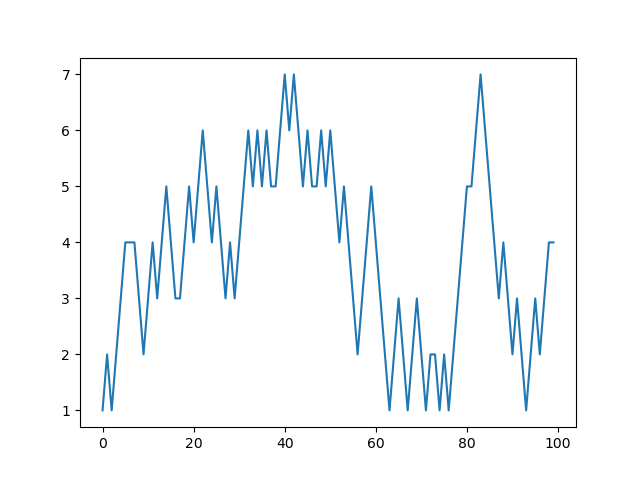

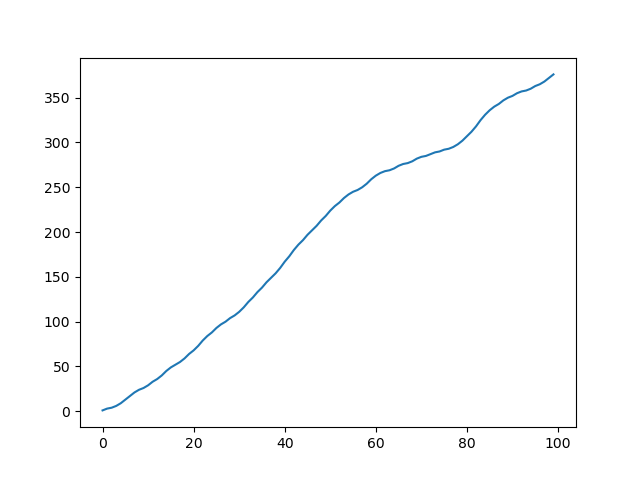

In [6]:
# random exploration example
env.reset()
rewards = []
while True:
    state, reward, done, _ = env.step(env.action_space.sample())
    rewards.append(reward)
    env.render()
    if done:
        break
plt.figure()
sns.lineplot(rewards)
plt.show()
plt.figure()
sns.lineplot(torch.as_tensor(rewards).cumsum(dim=0).numpy())
plt.show()

In [7]:
env.action_space.sample()

0

In [8]:
env.observation_space.sample()

array([[[1.        , 0.42638323, 3.        , 1.        ],
        [0.        , 0.64251226, 2.        , 0.        ],
        [0.        , 0.9461516 , 4.        , 0.        ]],

       [[0.        , 0.07595391, 4.        , 1.        ],
        [1.        , 0.61591536, 4.        , 1.        ],
        [1.        , 0.00459144, 2.        , 0.        ]],

       [[1.        , 0.8180518 , 2.        , 0.        ],
        [0.        , 0.9977304 , 4.        , 1.        ],
        [0.        , 0.3834601 , 3.        , 0.        ]],

       [[1.        , 0.778303  , 2.        , 0.        ],
        [0.        , 0.68304485, 1.        , 0.        ],
        [1.        , 0.6389745 , 2.        , 0.        ]],

       [[1.        , 0.8923049 , 4.        , 1.        ],
        [0.        , 0.4732669 , 3.        , 1.        ],
        [0.        , 0.5280015 , 4.        , 1.        ]]], dtype=float32)

In [9]:
env.reset()
env.step(1)

(tensor([[[0.0000, 0.0000, 1.0000, 0.0000]],
 
         [[1.0000, 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.7733, 1.0000, 1.0000]],
 
         [[0.0000, 0.0000, 2.0000, 0.0000]],
 
         [[0.0000, 0.1828, 2.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 2.0000, 0.0000]],
 
         [[0.0000, 0.0000, 3.0000, 0.0000]],
 
         [[0.0000, 0.0000, 1.0000, 0.0000]]]),
 1,
 False,
 {})

In [10]:
class DQN(nn.Module):
    def __init__(self, num_vehicles: int, num_vulns: int, num_actions: int):
        super().__init__()
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_vehicles * num_vulns * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.out = nn.Linear(128 + num_vehicles * num_vulns * 4, num_actions)


    def forward(self, state: Tensor) -> Tensor:
        x: Tensor = self.main(state.permute(0,3,1,2))
        # skip connection cause why not
        x = torch.hstack((x, state.flatten(start_dim=1)))
        x = self.out(x)
        return x

In [11]:
# weight update functions
# from https://github.com/ghliu/pytorch-ddpg/blob/master/util.py#L26
def soft_update(target, source, tau):
    # using .parameters() doesn't include all params for batchnorm causing issues
    for (k1, v1), (k2, v2) in zip(target.state_dict().items(), source.state_dict().items()):
        assert k1 == k2
        v1.copy_(v1 * (1.0 - tau) + v2 * tau)
        # target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    target.load_state_dict(source.state_dict())
    # for target_param, param in zip(target.parameters(), source.parameters()):
    #         target_param.data.copy_(param.data)

In [12]:
policy = DQN(NUM_VEHICLES, NUM_VULNS, env.action_space.n)
policy_target = DQN(NUM_VEHICLES, NUM_VULNS, env.action_space.n)
policy_target.eval()
hard_update(policy_target, policy)

In [13]:
def get_action(state: Tensor, epsilon: float) -> int:
    if random.random() < epsilon:
        return env.action_space.sample()
    state_batch = state.unsqueeze(0)
    policy.eval()
    with torch.no_grad():
        q_values = policy(state_batch)
    return int(q_values.argmax(dim=1).squeeze()) # return action with highest q-value

In [14]:
get_action(env.reset(), 0)

8

In [15]:
# transitions
@dataclass
class Transition:
    state: Tensor
    action: int
    reward: float
    next_state: Tensor
    terminal: bool

@dataclass
class TransitionBatch:
    states: Tensor
    actions: Tensor
    rewards: Tensor
    next_states: Tensor
    terminals: Tensor

In [16]:
memory: deque[Transition] = deque(maxlen=MEMORY_SIZE)

In [17]:
def sample_memory(batch_size: int) -> TransitionBatch:
    samples = random.sample(memory, batch_size)
    return TransitionBatch(
        states=torch.stack([s.state for s in samples]),
        actions=torch.as_tensor([s.action for s in samples], dtype=torch.int64),
        rewards=torch.as_tensor([s.reward for s in samples], dtype=torch.float32),
        next_states=torch.stack([s.next_state for s in samples]),
        terminals=torch.as_tensor([s.terminal for s in samples], dtype=torch.bool),
    )

In [18]:
optimizer = torch.optim.RMSprop(policy.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.9,
    patience=500,
    cooldown=500,
    min_lr=0.00001,
    verbose=True,
)

In [19]:
loss_history: List[float] = []
learning_rate_history: List[float] = []
reward_history: List[float] = []
duration_history: List[int] = []
action_history: List[int] = []
terminal_history: List[bool] = []
platoon_size_history: List[int] = []
platoon_compromise_count_history: List[int] = []
platoon_compromise_impact_history: List[int] = []
episode_begin_steps: List[int] = []

In [20]:
steps_done = 0
episodes_done = 0
warmup_steps = max(BATCH_SIZE, MEMORY_WARMUP_STEPS)

In [21]:
# train loop
render_every_n_episodes = 1
with tqdm() as pbar:
    for episode in count():
        state = env.reset()
        reward_total = 0
        for i in count():
            # region exploration
            epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * ((steps_done-warmup_steps)/EPSILON_SCALE) / EPSILON_DECAY)
            steps_done += 1
            action = get_action(state, epsilon)
            next_state, reward, done, info = env.step(action)
            reward_total += reward
            if done:
                duration_history.append(i)
                next_state = torch.zeros(state.shape)
            else:
                next_state = torch.as_tensor(next_state, dtype=torch.float32)                
            memory.append(Transition(
                state=state,
                action=action,
                reward=reward,
                next_state=next_state,
                terminal=done,
            ))
            state = next_state
            if episode % render_every_n_episodes == 0:
                env.render()
            #endregion exploration

            if len(memory) < warmup_steps:
                pbar.set_description(f"warmup")
            else:
                policy.train()
                batch = sample_memory(BATCH_SIZE)

                # calculate q values for the actions that were taken
                q_pred = policy(batch.states).gather(1, batch.actions.unsqueeze(1))

                # calculate q values for next state
                q_next = torch.zeros(BATCH_SIZE)
                non_final = ~batch.terminals
                q_next[non_final] = policy_target(batch.next_states[non_final]).max(dim=1).values.detach()

                # calculate expected q values
                q_expected = ((q_next * REWARD_GAMMA) + batch.rewards).unsqueeze(1)

                # calculate loss
                policy_loss = F.smooth_l1_loss(q_pred, q_expected)

                # apply weight update
                optimizer.zero_grad()
                policy_loss.backward()
                for param in policy.parameters():
                    param.grad.data.clamp_(-1, 1)
                optimizer.step()
                
                # update learning rate
                scheduler.step(policy_loss)

                ## update target network
                if i % POLICY_TARGET_UPDATE_INTERVAL == 0:
                    soft_update(policy_target, policy, SOFT_UPDATE_TAU)
                    # hard_update(policy_target, policy)
                lr = optimizer.param_groups[0]["lr"]
                pbar.set_description(f"action: {action:02d}, policy_loss: {policy_loss.item():06.3f}, reward: {reward:+05.1f}, episode_reward: {reward_total:+07.1f}, epsilon: {epsilon:.3f}, lr: {lr:.6f}, steps: {steps_done}, episode: {episodes_done}.{i}")
                
                loss_history.append(policy_loss.item())
                learning_rate_history.append(lr)
                action_history.append(action)
                reward_history.append(reward)
                terminal_history.append(done)
                episode_begin_steps.append(i == 0)
                platoon_size_history.append(int(next_state[:,:,0].sum(dim=1).count_nonzero().item()))
                platoon_compromise_impact_history.append(int((next_state[:,:,0] * next_state[:,:,2] * next_state[:,:,3]).sum().item()))
                platoon_compromise_count_history.append(int((next_state[:,:,0] * next_state[:,:,3]).sum(dim=1).count_nonzero().item()))

            if done: break
            pbar.update()
        episodes_done += 1
env.close()

0it [00:00, ?it/s]

Epoch 00502: reducing learning rate of group 0 to 9.0000e-04.
Epoch 01503: reducing learning rate of group 0 to 8.1000e-04.
Epoch 02504: reducing learning rate of group 0 to 7.2900e-04.
Epoch 03505: reducing learning rate of group 0 to 6.5610e-04.
Epoch 04506: reducing learning rate of group 0 to 5.9049e-04.
Epoch 05507: reducing learning rate of group 0 to 5.3144e-04.
Epoch 06508: reducing learning rate of group 0 to 4.7830e-04.
Epoch 07509: reducing learning rate of group 0 to 4.3047e-04.
Epoch 08510: reducing learning rate of group 0 to 3.8742e-04.
Epoch 09511: reducing learning rate of group 0 to 3.4868e-04.
Epoch 10512: reducing learning rate of group 0 to 3.1381e-04.


KeyboardInterrupt: 

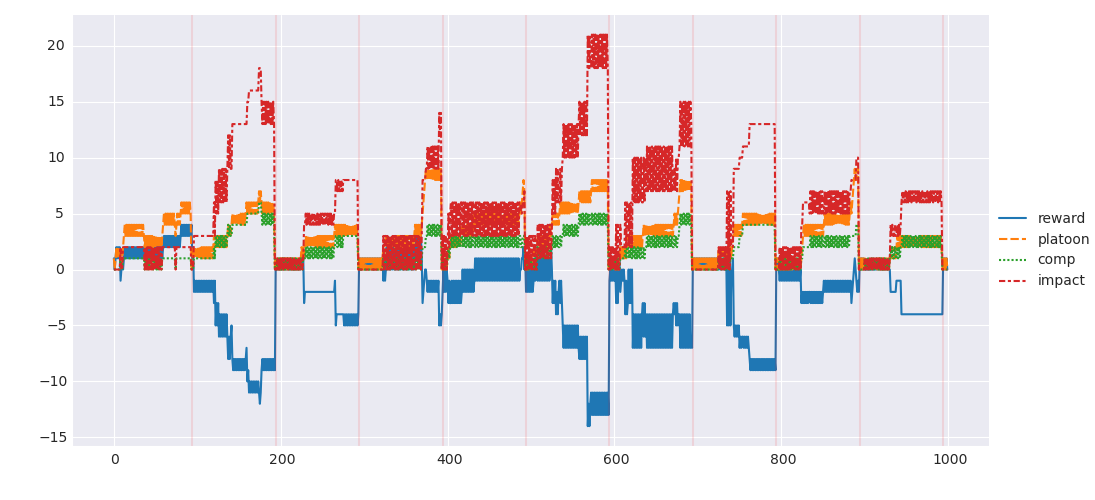

In [ ]:
last=1000
with sns.axes_style("darkgrid"):
    p = sns.relplot(data={
        "reward":reward_history[-last:],
        "platoon":platoon_size_history[-last:],
        "comp": platoon_compromise_count_history[-last:],
        "impact": platoon_compromise_impact_history[-last:],
    }, kind="line", height=5, aspect=2)
    for i,x in enumerate(episode_begin_steps[-last:]):
        if x == True:
            plt.axvline(x=i, color="red", alpha=0.1)
    # p.fig.set_dpi(500)